In [1]:
from super_gradients import Trainer
from super_gradients.training import  MultiGPUMode
from torch.utils.data import Dataset, DataLoader
from super_gradients.training import models
from super_gradients.common.object_names import Models
from super_gradients.training.metrics.segmentation_metrics import IoU
from super_gradients.training.losses import iou_loss
from super_gradients.training.utils.callbacks import BinarySegmentationVisualizationCallback, Phase
import torch
import os

import sys
sys.path.insert(0, '../../')

from research.dataloaders.rzd_railway_segmentation import RailwaySegmentation

[2023-09-22 12:02:02] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/alexey/sg_logs/console.log


/home/alexey/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023-09-22 12:02:04.605139: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 12:02:04.642270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CHECKPOINT_DIR = '/media/alexey/SSDData/experiments/railway_segmentation/super_gradients'
trainer = Trainer(experiment_name='PP_LITE_T_SEG75_ms', ckpt_root_dir=CHECKPOINT_DIR)

In [3]:
size = 1024

train_dataset = RailwaySegmentation(
    '/media/alexey/SSDData/datasets/railway/RZD_Segmentation/train/', size,
    apply_augmentations=True
)
val_dataset = RailwaySegmentation('/media/alexey/SSDData/datasets/railway/RZD_Segmentation/val/', size)

nc = train_dataset.get_num_classes()

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [5]:
model = models.get(model_name=Models.PP_LITE_T_SEG75,
                   arch_params={"use_aux_heads": False},
                   num_classes=nc,
                   pretrained_weights="cityscapes")
                   # checkpoint_path=os.path.join(CHECKPOINT_DIR, 'PP_LITE_T_SEG75_ms/', 'ckpt_latest.pth'))

In [6]:
train_params = {"max_epochs": 250,
                "lr_mode": "cosine",
#                 "resume": True,
#                 "resume_path": os.path.join(CHECKPOINT_DIR, 'PP_LITE_T_SEG75_ms/', 'ckpt_latest.pth'),
                "initial_lr": 0.005,
                "optimizer": "ADAMW",
                "loss": iou_loss.GeneralizedIoULoss(),
                "average_best_models": False,
                "metric_to_watch": "IoU",
                "greater_metric_to_watch_is_better": True,
                "train_metrics_list": [IoU(num_classes=nc)],
                "valid_metrics_list": [IoU(num_classes=nc)],
                "loss_logging_items_names": ["loss"],
                "phase_callbacks": [BinarySegmentationVisualizationCallback(phase=Phase.VALIDATION_BATCH_END,
                                                                            freq=1,
                                                                            last_img_idx_in_batch=4)],

                }

I0922 12:02:06.728815 139974484674368 env_sanity_check.py:109] torch==2.0.1+cu118 does not satisfy requirement torch<1.14,>=1.9.0
I0922 12:02:06.731374 139974484674368 env_sanity_check.py:109] pycocotools==2.0.6 does not satisfy requirement pycocotools==2.0.4


In [7]:
%load_ext tensorboard
%tensorboard --logdir $CHECKPOINT_DIR --bind_all

In [ ]:
trainer.train(
    model=model, 
    training_params=train_params, 
    train_loader=train_dataloader, 
    valid_loader=val_dataloader
)

[2023-09-22 12:02:53] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
W0922 12:02:53.931535 139974484674368 sg_trainer.py:1009] Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-09-22 12:02:55] WARNING - callbacks.py - Parameter linear_step has been made deprecated and will be removed in the next SG release. Please use `linear_epoch_step` instead.
W0922 12:02:55.750651 139974484674368 callbacks.py:283] Parameter linear_step has been made deprecated and will be removed in the next SG release. Please use `linear_epoch_step` instead.


The console stream is now moved to /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/console_сен22_12_02_55.txt


[2023-09-22 12:03:06] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 8051       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         504        (len(train_loader))
    - Gradient updates per epoch:   504        (len(train_loader) / batch_accumulate)

[2023-09-22 12:03:06] INFO - sg_trainer.py - Started training for 250 epochs (0/249)

Train epoch 0: 100%|██████████| 504/504 [03:34<00:00,  2.34it/s, GeneralizedIoUL
Validation epoch 0: 100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Generalizediouloss = 0.4921
│   └── Iou = 0.4947
└── Validation
    ├── Generalizediouloss = 0.3977
    └── Iou = 0.6168



[2023-09-22 12:06:48] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 12:06:48] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.6167725324630737
Train epoch 1: 100%|██████████| 504/504 [03:32<00:00,  2.37it/s, GeneralizedIoUL
Validation epoch 1: 100%|██████████| 38/38 [00:06<00:00,  6.01it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Generalizediouloss = 0.3903
│   │   ├── Best until now = 0.4921 (↘ -0.1019)
│   │   └── Epoch N-1      = 0.4921 (↘ -0.1019)
│   └── Iou = 0.6092
│       ├── Best until now = 0.4947 (↗ 0.1145)
│       └── Epoch N-1      = 0.4947 (↗ 0.1145)
└── Validation
    ├── Generalizediouloss = 0.396
    │   ├── Best until now = 0.3977 (↘ -0.0017)
    │   └── Epoch N-1      = 0.3977 (↘ -0.0017)
    └── Iou = 0.6133
        ├── Best until now = 0.6168 (↘ -0.0035)
        └── Epoch N-1      = 0.6168 (↘ -0.0035)



Train epoch 2: 100%|██████████| 504/504 [03:32<00:00,  2.38it/s, GeneralizedIoUL
Validation epoch 2: 100%|██████████| 38/38 [00:06<00:00,  6.01it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Generalizediouloss = 0.3433
│   │   ├── Best until now = 0.3903 (↘ -0.0469)
│   │   └── Epoch N-1      = 0.3903 (↘ -0.0469)
│   └── Iou = 0.6565
│       ├── Best until now = 0.6092 (↗ 0.0473)
│       └── Epoch N-1      = 0.6092 (↗ 0.0473)
└── Validation
    ├── Generalizediouloss = 0.3169
    │   ├── Best until now = 0.396  (↘ -0.0791)
    │   └── Epoch N-1      = 0.396  (↘ -0.0791)
    └── Iou = 0.7029
        ├── Best until now = 0.6168 (↗ 0.0861)
        └── Epoch N-1      = 0.6133 (↗ 0.0896)



[2023-09-22 12:14:07] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 12:14:07] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7028518319129944
Train epoch 3: 100%|██████████| 504/504 [03:33<00:00,  2.36it/s, GeneralizedIoUL
Validation epoch 3: 100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Generalizediouloss = 0.3152
│   │   ├── Best until now = 0.3433 (↘ -0.0281)
│   │   └── Epoch N-1      = 0.3433 (↘ -0.0281)
│   └── Iou = 0.6851
│       ├── Best until now = 0.6565 (↗ 0.0287)
│       └── Epoch N-1      = 0.6565 (↗ 0.0287)
└── Validation
    ├── Generalizediouloss = 0.3329
    │   ├── Best until now = 0.3169 (↗ 0.016)
    │   └── Epoch N-1      = 0.3169 (↗ 0.016)
    └── Iou = 0.6757
        ├── Best until now = 0.7029 (↘ -0.0272)
        └── Epoch N-1      = 0.7029 (↘ -0.0272)



Train epoch 4: 100%|██████████| 504/504 [03:34<00:00,  2.35it/s, GeneralizedIoUL
Validation epoch 4: 100%|██████████| 38/38 [00:06<00:00,  5.99it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Generalizediouloss = 0.2973
│   │   ├── Best until now = 0.3152 (↘ -0.018)
│   │   └── Epoch N-1      = 0.3152 (↘ -0.018)
│   └── Iou = 0.7034
│       ├── Best until now = 0.6851 (↗ 0.0183)
│       └── Epoch N-1      = 0.6851 (↗ 0.0183)
└── Validation
    ├── Generalizediouloss = 0.3171
    │   ├── Best until now = 0.3169 (↗ 0.0002)
    │   └── Epoch N-1      = 0.3329 (↘ -0.0158)
    └── Iou = 0.7045
        ├── Best until now = 0.7029 (↗ 0.0017)
        └── Epoch N-1      = 0.6757 (↗ 0.0288)



[2023-09-22 12:21:28] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 12:21:28] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7045270800590515
Train epoch 5: 100%|██████████| 504/504 [03:34<00:00,  2.35it/s, GeneralizedIoUL
Validation epoch 5: 100%|██████████| 38/38 [00:06<00:00,  5.90it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Generalizediouloss = 0.2894
│   │   ├── Best until now = 0.2973 (↘ -0.0078)
│   │   └── Epoch N-1      = 0.2973 (↘ -0.0078)
│   └── Iou = 0.7129
│       ├── Best until now = 0.7034 (↗ 0.0094)
│       └── Epoch N-1      = 0.7034 (↗ 0.0094)
└── Validation
    ├── Generalizediouloss = 0.3346
    │   ├── Best until now = 0.3169 (↗ 0.0177)
    │   └── Epoch N-1      = 0.3171 (↗ 0.0175)
    └── Iou = 0.6814
        ├── Best until now = 0.7045 (↘ -0.0232)
        └── Epoch N-1      = 0.7045 (↘ -0.0232)



Train epoch 6: 100%|██████████| 504/504 [03:36<00:00,  2.33it/s, GeneralizedIoUL
Validation epoch 6: 100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Generalizediouloss = 0.2796
│   │   ├── Best until now = 0.2894 (↘ -0.0098)
│   │   └── Epoch N-1      = 0.2894 (↘ -0.0098)
│   └── Iou = 0.7238
│       ├── Best until now = 0.7129 (↗ 0.011)
│       └── Epoch N-1      = 0.7129 (↗ 0.011)
└── Validation
    ├── Generalizediouloss = 0.2762
    │   ├── Best until now = 0.3169 (↘ -0.0407)
    │   └── Epoch N-1      = 0.3346 (↘ -0.0584)
    └── Iou = 0.7504
        ├── Best until now = 0.7045 (↗ 0.0458)
        └── Epoch N-1      = 0.6814 (↗ 0.069)



[2023-09-22 12:28:53] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 12:28:53] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7503522038459778
Train epoch 7: 100%|██████████| 504/504 [03:39<00:00,  2.30it/s, GeneralizedIoUL
Validation epoch 7: 100%|██████████| 38/38 [00:06<00:00,  5.95it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Generalizediouloss = 0.2764
│   │   ├── Best until now = 0.2796 (↘ -0.0032)
│   │   └── Epoch N-1      = 0.2796 (↘ -0.0032)
│   └── Iou = 0.7251
│       ├── Best until now = 0.7238 (↗ 0.0013)
│       └── Epoch N-1      = 0.7238 (↗ 0.0013)
└── Validation
    ├── Generalizediouloss = 0.296
    │   ├── Best until now = 0.2762 (↗ 0.0197)
    │   └── Epoch N-1      = 0.2762 (↗ 0.0197)
    └── Iou = 0.723
        ├── Best until now = 0.7504 (↘ -0.0274)
        └── Epoch N-1      = 0.7504 (↘ -0.0274)



Train epoch 8: 100%|██████████| 504/504 [03:38<00:00,  2.31it/s, GeneralizedIoUL
Validation epoch 8: 100%|██████████| 38/38 [00:06<00:00,  5.87it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Generalizediouloss = 0.2554
│   │   ├── Best until now = 0.2764 (↘ -0.021)
│   │   └── Epoch N-1      = 0.2764 (↘ -0.021)
│   └── Iou = 0.7463
│       ├── Best until now = 0.7251 (↗ 0.0212)
│       └── Epoch N-1      = 0.7251 (↗ 0.0212)
└── Validation
    ├── Generalizediouloss = 0.2591
    │   ├── Best until now = 0.2762 (↘ -0.0171)
    │   └── Epoch N-1      = 0.296  (↘ -0.0369)
    └── Iou = 0.7725
        ├── Best until now = 0.7504 (↗ 0.0221)
        └── Epoch N-1      = 0.723  (↗ 0.0495)



[2023-09-22 12:36:25] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 12:36:25] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7724999189376831
Train epoch 9: 100%|██████████| 504/504 [03:37<00:00,  2.31it/s, GeneralizedIoUL
Validation epoch 9: 100%|██████████| 38/38 [00:06<00:00,  5.83it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Generalizediouloss = 0.2529
│   │   ├── Best until now = 0.2554 (↘ -0.0024)
│   │   └── Epoch N-1      = 0.2554 (↘ -0.0024)
│   └── Iou = 0.7502
│       ├── Best until now = 0.7463 (↗ 0.0039)
│       └── Epoch N-1      = 0.7463 (↗ 0.0039)
└── Validation
    ├── Generalizediouloss = 0.2548
    │   ├── Best until now = 0.2591 (↘ -0.0043)
    │   └── Epoch N-1      = 0.2591 (↘ -0.0043)
    └── Iou = 0.7676
        ├── Best until now = 0.7725 (↘ -0.0049)
        └── Epoch N-1      = 0.7725 (↘ -0.0049)



Train epoch 10: 100%|██████████| 504/504 [03:39<00:00,  2.29it/s, GeneralizedIoU
Validation epoch 10: 100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Generalizediouloss = 0.2451
│   │   ├── Best until now = 0.2529 (↘ -0.0078)
│   │   └── Epoch N-1      = 0.2529 (↘ -0.0078)
│   └── Iou = 0.7587
│       ├── Best until now = 0.7502 (↗ 0.0085)
│       └── Epoch N-1      = 0.7502 (↗ 0.0085)
└── Validation
    ├── Generalizediouloss = 0.2577
    │   ├── Best until now = 0.2548 (↗ 0.0029)
    │   └── Epoch N-1      = 0.2548 (↗ 0.0029)
    └── Iou = 0.7662
        ├── Best until now = 0.7725 (↘ -0.0063)
        └── Epoch N-1      = 0.7676 (↘ -0.0014)



Train epoch 11: 100%|██████████| 504/504 [03:43<00:00,  2.26it/s, GeneralizedIoU
Validation epoch 11: 100%|██████████| 38/38 [00:06<00:00,  5.71it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Generalizediouloss = 0.2452
│   │   ├── Best until now = 0.2451 (↗ 1e-04)
│   │   └── Epoch N-1      = 0.2451 (↗ 1e-04)
│   └── Iou = 0.7578
│       ├── Best until now = 0.7587 (↘ -0.0009)
│       └── Epoch N-1      = 0.7587 (↘ -0.0009)
└── Validation
    ├── Generalizediouloss = 0.2501
    │   ├── Best until now = 0.2548 (↘ -0.0047)
    │   └── Epoch N-1      = 0.2577 (↘ -0.0076)
    └── Iou = 0.7708
        ├── Best until now = 0.7725 (↘ -0.0017)
        └── Epoch N-1      = 0.7662 (↗ 0.0046)



Train epoch 12: 100%|██████████| 504/504 [03:46<00:00,  2.23it/s, GeneralizedIoU
Validation epoch 12: 100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Generalizediouloss = 0.2448
│   │   ├── Best until now = 0.2451 (↘ -0.0003)
│   │   └── Epoch N-1      = 0.2452 (↘ -0.0004)
│   └── Iou = 0.7573
│       ├── Best until now = 0.7587 (↘ -0.0014)
│       └── Epoch N-1      = 0.7578 (↘ -0.0005)
└── Validation
    ├── Generalizediouloss = 0.2669
    │   ├── Best until now = 0.2501 (↗ 0.0168)
    │   └── Epoch N-1      = 0.2501 (↗ 0.0168)
    └── Iou = 0.7596
        ├── Best until now = 0.7725 (↘ -0.0129)
        └── Epoch N-1      = 0.7708 (↘ -0.0112)



Train epoch 13: 100%|██████████| 504/504 [03:42<00:00,  2.27it/s, GeneralizedIoU
Validation epoch 13: 100%|██████████| 38/38 [00:06<00:00,  5.83it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Generalizediouloss = 0.2372
│   │   ├── Best until now = 0.2448 (↘ -0.0076)
│   │   └── Epoch N-1      = 0.2448 (↘ -0.0076)
│   └── Iou = 0.7663
│       ├── Best until now = 0.7587 (↗ 0.0076)
│       └── Epoch N-1      = 0.7573 (↗ 0.0091)
└── Validation
    ├── Generalizediouloss = 0.2653
    │   ├── Best until now = 0.2501 (↗ 0.0152)
    │   └── Epoch N-1      = 0.2669 (↘ -0.0016)
    └── Iou = 0.7566
        ├── Best until now = 0.7725 (↘ -0.0159)
        └── Epoch N-1      = 0.7596 (↘ -0.003)



Train epoch 14: 100%|██████████| 504/504 [03:38<00:00,  2.31it/s, GeneralizedIoU
Validation epoch 14: 100%|██████████| 38/38 [00:06<00:00,  5.84it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Generalizediouloss = 0.2399
│   │   ├── Best until now = 0.2372 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.2372 (↗ 0.0027)
│   └── Iou = 0.764
│       ├── Best until now = 0.7663 (↘ -0.0023)
│       └── Epoch N-1      = 0.7663 (↘ -0.0023)
└── Validation
    ├── Generalizediouloss = 0.2859
    │   ├── Best until now = 0.2501 (↗ 0.0358)
    │   └── Epoch N-1      = 0.2653 (↗ 0.0206)
    └── Iou = 0.7303
        ├── Best until now = 0.7725 (↘ -0.0422)
        └── Epoch N-1      = 0.7566 (↘ -0.0263)



Train epoch 15: 100%|██████████| 504/504 [03:37<00:00,  2.32it/s, GeneralizedIoU
Validation epoch 15: 100%|██████████| 38/38 [00:06<00:00,  5.75it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Generalizediouloss = 0.229
│   │   ├── Best until now = 0.2372 (↘ -0.0082)
│   │   └── Epoch N-1      = 0.2399 (↘ -0.0109)
│   └── Iou = 0.7757
│       ├── Best until now = 0.7663 (↗ 0.0094)
│       └── Epoch N-1      = 0.764  (↗ 0.0117)
└── Validation
    ├── Generalizediouloss = 0.2378
    │   ├── Best until now = 0.2501 (↘ -0.0122)
    │   └── Epoch N-1      = 0.2859 (↘ -0.0481)
    └── Iou = 0.7854
        ├── Best until now = 0.7725 (↗ 0.0129)
        └── Epoch N-1      = 0.7303 (↗ 0.0551)



[2023-09-22 13:02:59] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:02:59] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7853786945343018
Train epoch 16: 100%|██████████| 504/504 [03:35<00:00,  2.34it/s, GeneralizedIoU
Validation epoch 16: 100%|██████████| 38/38 [00:06<00:00,  5.86it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Generalizediouloss = 0.2316
│   │   ├── Best until now = 0.229  (↗ 0.0026)
│   │   └── Epoch N-1      = 0.229  (↗ 0.0026)
│   └── Iou = 0.7709
│       ├── Best until now = 0.7757 (↘ -0.0048)
│       └── Epoch N-1      = 0.7757 (↘ -0.0048)
└── Validation
    ├── Generalizediouloss = 0.2351
    │   ├── Best until now = 0.2378 (↘ -0.0027)
    │   └── Epoch N-1      = 0.2378 (↘ -0.0027)
    └── Iou = 0.7937
        ├── Best until now = 0.7854 (↗ 0.0083)
        └── Epoch N-1      = 0.7854 (↗ 0.0083)



[2023-09-22 13:06:42] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:06:42] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.793694794178009
Train epoch 17: 100%|██████████| 504/504 [03:38<00:00,  2.30it/s, GeneralizedIoU
Validation epoch 17: 100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Generalizediouloss = 0.2295
│   │   ├── Best until now = 0.229  (↗ 0.0005)
│   │   └── Epoch N-1      = 0.2316 (↘ -0.0021)
│   └── Iou = 0.7738
│       ├── Best until now = 0.7757 (↘ -0.0019)
│       └── Epoch N-1      = 0.7709 (↗ 0.0029)
└── Validation
    ├── Generalizediouloss = 0.263
    │   ├── Best until now = 0.2351 (↗ 0.0279)
    │   └── Epoch N-1      = 0.2351 (↗ 0.0279)
    └── Iou = 0.7644
        ├── Best until now = 0.7937 (↘ -0.0293)
        └── Epoch N-1      = 0.7937 (↘ -0.0293)



Train epoch 18: 100%|██████████| 504/504 [03:35<00:00,  2.33it/s, GeneralizedIoU
Validation epoch 18: 100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Generalizediouloss = 0.2216
│   │   ├── Best until now = 0.229  (↘ -0.0074)
│   │   └── Epoch N-1      = 0.2295 (↘ -0.0079)
│   └── Iou = 0.7828
│       ├── Best until now = 0.7757 (↗ 0.0071)
│       └── Epoch N-1      = 0.7738 (↗ 0.0089)
└── Validation
    ├── Generalizediouloss = 0.2283
    │   ├── Best until now = 0.2351 (↘ -0.0068)
    │   └── Epoch N-1      = 0.263  (↘ -0.0347)
    └── Iou = 0.7956
        ├── Best until now = 0.7937 (↗ 0.002)
        └── Epoch N-1      = 0.7644 (↗ 0.0313)



[2023-09-22 13:14:11] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:14:11] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7956498861312866
Train epoch 19: 100%|██████████| 504/504 [03:35<00:00,  2.34it/s, GeneralizedIoU
Validation epoch 19: 100%|██████████| 38/38 [00:06<00:00,  5.96it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Generalizediouloss = 0.2305
│   │   ├── Best until now = 0.2216 (↗ 0.0089)
│   │   └── Epoch N-1      = 0.2216 (↗ 0.0089)
│   └── Iou = 0.7734
│       ├── Best until now = 0.7828 (↘ -0.0094)
│       └── Epoch N-1      = 0.7828 (↘ -0.0094)
└── Validation
    ├── Generalizediouloss = 0.2379
    │   ├── Best until now = 0.2283 (↗ 0.0096)
    │   └── Epoch N-1      = 0.2283 (↗ 0.0096)
    └── Iou = 0.7857
        ├── Best until now = 0.7956 (↘ -0.0099)
        └── Epoch N-1      = 0.7956 (↘ -0.0099)



Train epoch 20: 100%|██████████| 504/504 [03:38<00:00,  2.31it/s, GeneralizedIoU
Validation epoch 20: 100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Generalizediouloss = 0.221
│   │   ├── Best until now = 0.2216 (↘ -0.0006)
│   │   └── Epoch N-1      = 0.2305 (↘ -0.0096)
│   └── Iou = 0.7832
│       ├── Best until now = 0.7828 (↗ 0.0005)
│       └── Epoch N-1      = 0.7734 (↗ 0.0099)
└── Validation
    ├── Generalizediouloss = 0.2196
    │   ├── Best until now = 0.2283 (↘ -0.0087)
    │   └── Epoch N-1      = 0.2379 (↘ -0.0182)
    └── Iou = 0.7998
        ├── Best until now = 0.7956 (↗ 0.0042)
        └── Epoch N-1      = 0.7857 (↗ 0.0141)



[2023-09-22 13:21:38] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:21:38] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7998387813568115
Train epoch 21: 100%|██████████| 504/504 [03:40<00:00,  2.28it/s, GeneralizedIoU
Validation epoch 21: 100%|██████████| 38/38 [00:06<00:00,  5.72it/s]


SUMMARY OF EPOCH 21
├── Training
│   ├── Generalizediouloss = 0.2177
│   │   ├── Best until now = 0.221  (↘ -0.0033)
│   │   └── Epoch N-1      = 0.221  (↘ -0.0033)
│   └── Iou = 0.787
│       ├── Best until now = 0.7832 (↗ 0.0037)
│       └── Epoch N-1      = 0.7832 (↗ 0.0037)
└── Validation
    ├── Generalizediouloss = 0.2279
    │   ├── Best until now = 0.2196 (↗ 0.0082)
    │   └── Epoch N-1      = 0.2196 (↗ 0.0082)
    └── Iou = 0.8037
        ├── Best until now = 0.7998 (↗ 0.0039)
        └── Epoch N-1      = 0.7998 (↗ 0.0039)



[2023-09-22 13:25:26] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:25:26] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.803743839263916
Train epoch 22: 100%|██████████| 504/504 [03:36<00:00,  2.33it/s, GeneralizedIoU
Validation epoch 22: 100%|██████████| 38/38 [00:06<00:00,  5.87it/s]


SUMMARY OF EPOCH 22
├── Training
│   ├── Generalizediouloss = 0.2162
│   │   ├── Best until now = 0.2177 (↘ -0.0015)
│   │   └── Epoch N-1      = 0.2177 (↘ -0.0015)
│   └── Iou = 0.7888
│       ├── Best until now = 0.787  (↗ 0.0018)
│       └── Epoch N-1      = 0.787  (↗ 0.0018)
└── Validation
    ├── Generalizediouloss = 0.2297
    │   ├── Best until now = 0.2196 (↗ 0.0101)
    │   └── Epoch N-1      = 0.2279 (↗ 0.0019)
    └── Iou = 0.7983
        ├── Best until now = 0.8037 (↘ -0.0054)
        └── Epoch N-1      = 0.8037 (↘ -0.0054)



Train epoch 23: 100%|██████████| 504/504 [03:37<00:00,  2.32it/s, GeneralizedIoU
Validation epoch 23: 100%|██████████| 38/38 [00:06<00:00,  5.92it/s]


SUMMARY OF EPOCH 23
├── Training
│   ├── Generalizediouloss = 0.217
│   │   ├── Best until now = 0.2162 (↗ 0.0009)
│   │   └── Epoch N-1      = 0.2162 (↗ 0.0009)
│   └── Iou = 0.787
│       ├── Best until now = 0.7888 (↘ -0.0017)
│       └── Epoch N-1      = 0.7888 (↘ -0.0017)
└── Validation
    ├── Generalizediouloss = 0.2566
    │   ├── Best until now = 0.2196 (↗ 0.037)
    │   └── Epoch N-1      = 0.2297 (↗ 0.0269)
    └── Iou = 0.7603
        ├── Best until now = 0.8037 (↘ -0.0435)
        └── Epoch N-1      = 0.7983 (↘ -0.0381)



Train epoch 24: 100%|██████████| 504/504 [03:36<00:00,  2.33it/s, GeneralizedIoU
Validation epoch 24: 100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


SUMMARY OF EPOCH 24
├── Training
│   ├── Generalizediouloss = 0.2145
│   │   ├── Best until now = 0.2162 (↘ -0.0017)
│   │   └── Epoch N-1      = 0.217  (↘ -0.0026)
│   └── Iou = 0.7886
│       ├── Best until now = 0.7888 (↘ -0.0001)
│       └── Epoch N-1      = 0.787  (↗ 0.0016)
└── Validation
    ├── Generalizediouloss = 0.2266
    │   ├── Best until now = 0.2196 (↗ 0.0069)
    │   └── Epoch N-1      = 0.2566 (↘ -0.03)
    └── Iou = 0.8017
        ├── Best until now = 0.8037 (↘ -0.002)
        └── Epoch N-1      = 0.7603 (↗ 0.0414)



Train epoch 25: 100%|██████████| 504/504 [03:35<00:00,  2.34it/s, GeneralizedIoU
Validation epoch 25: 100%|██████████| 38/38 [00:06<00:00,  5.96it/s]


SUMMARY OF EPOCH 25
├── Training
│   ├── Generalizediouloss = 0.216
│   │   ├── Best until now = 0.2145 (↗ 0.0015)
│   │   └── Epoch N-1      = 0.2145 (↗ 0.0015)
│   └── Iou = 0.7886
│       ├── Best until now = 0.7888 (↘ -0.0001)
│       └── Epoch N-1      = 0.7886 (↗ 0.0)
└── Validation
    ├── Generalizediouloss = 0.2145
    │   ├── Best until now = 0.2196 (↘ -0.0051)
    │   └── Epoch N-1      = 0.2266 (↘ -0.012)
    └── Iou = 0.8078
        ├── Best until now = 0.8037 (↗ 0.0041)
        └── Epoch N-1      = 0.8017 (↗ 0.0061)



[2023-09-22 13:40:20] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:40:20] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.8078217506408691
Train epoch 26: 100%|██████████| 504/504 [03:35<00:00,  2.34it/s, GeneralizedIoU
Validation epoch 26: 100%|██████████| 38/38 [00:06<00:00,  5.91it/s]


SUMMARY OF EPOCH 26
├── Training
│   ├── Generalizediouloss = 0.2093
│   │   ├── Best until now = 0.2145 (↘ -0.0051)
│   │   └── Epoch N-1      = 0.216  (↘ -0.0067)
│   └── Iou = 0.7948
│       ├── Best until now = 0.7888 (↗ 0.0061)
│       └── Epoch N-1      = 0.7886 (↗ 0.0062)
└── Validation
    ├── Generalizediouloss = 0.2086
    │   ├── Best until now = 0.2145 (↘ -0.006)
    │   └── Epoch N-1      = 0.2145 (↘ -0.006)
    └── Iou = 0.8138
        ├── Best until now = 0.8078 (↗ 0.006)
        └── Epoch N-1      = 0.8078 (↗ 0.006)



[2023-09-22 13:44:02] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:44:02] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.8138211965560913
Train epoch 27: 100%|██████████| 504/504 [03:36<00:00,  2.33it/s, GeneralizedIoU
Validation epoch 27: 100%|██████████| 38/38 [00:06<00:00,  5.94it/s]


SUMMARY OF EPOCH 27
├── Training
│   ├── Generalizediouloss = 0.2088
│   │   ├── Best until now = 0.2093 (↘ -0.0006)
│   │   └── Epoch N-1      = 0.2093 (↘ -0.0006)
│   └── Iou = 0.7946
│       ├── Best until now = 0.7948 (↘ -0.0003)
│       └── Epoch N-1      = 0.7948 (↘ -0.0003)
└── Validation
    ├── Generalizediouloss = 0.2219
    │   ├── Best until now = 0.2086 (↗ 0.0133)
    │   └── Epoch N-1      = 0.2086 (↗ 0.0133)
    └── Iou = 0.8059
        ├── Best until now = 0.8138 (↘ -0.0079)
        └── Epoch N-1      = 0.8138 (↘ -0.0079)



Train epoch 28: 100%|██████████| 504/504 [03:31<00:00,  2.38it/s, GeneralizedIoU
Validation epoch 28: 100%|██████████| 38/38 [00:06<00:00,  5.94it/s]


SUMMARY OF EPOCH 28
├── Training
│   ├── Generalizediouloss = 0.2096
│   │   ├── Best until now = 0.2088 (↗ 0.0008)
│   │   └── Epoch N-1      = 0.2088 (↗ 0.0008)
│   └── Iou = 0.795
│       ├── Best until now = 0.7948 (↗ 0.0001)
│       └── Epoch N-1      = 0.7946 (↗ 0.0004)
└── Validation
    ├── Generalizediouloss = 0.2355
    │   ├── Best until now = 0.2086 (↗ 0.0269)
    │   └── Epoch N-1      = 0.2219 (↗ 0.0136)
    └── Iou = 0.7878
        ├── Best until now = 0.8138 (↘ -0.026)
        └── Epoch N-1      = 0.8059 (↘ -0.018)



Train epoch 29: 100%|██████████| 504/504 [03:53<00:00,  2.16it/s, GeneralizedIoU
Validation epoch 29: 100%|██████████| 38/38 [00:06<00:00,  5.86it/s]


SUMMARY OF EPOCH 29
├── Training
│   ├── Generalizediouloss = 0.2052
│   │   ├── Best until now = 0.2088 (↘ -0.0035)
│   │   └── Epoch N-1      = 0.2096 (↘ -0.0044)
│   └── Iou = 0.7986
│       ├── Best until now = 0.795  (↗ 0.0037)
│       └── Epoch N-1      = 0.795  (↗ 0.0037)
└── Validation
    ├── Generalizediouloss = 0.2249
    │   ├── Best until now = 0.2086 (↗ 0.0164)
    │   └── Epoch N-1      = 0.2355 (↘ -0.0106)
    └── Iou = 0.8053
        ├── Best until now = 0.8138 (↘ -0.0085)
        └── Epoch N-1      = 0.7878 (↗ 0.0175)



Train epoch 30: 100%|██████████| 504/504 [03:33<00:00,  2.37it/s, GeneralizedIoU
Validation epoch 30: 100%|██████████| 38/38 [00:06<00:00,  5.87it/s]


SUMMARY OF EPOCH 30
├── Training
│   ├── Generalizediouloss = 0.2035
│   │   ├── Best until now = 0.2052 (↘ -0.0018)
│   │   └── Epoch N-1      = 0.2052 (↘ -0.0018)
│   └── Iou = 0.7998
│       ├── Best until now = 0.7986 (↗ 0.0012)
│       └── Epoch N-1      = 0.7986 (↗ 0.0012)
└── Validation
    ├── Generalizediouloss = 0.2063
    │   ├── Best until now = 0.2086 (↘ -0.0023)
    │   └── Epoch N-1      = 0.2249 (↘ -0.0186)
    └── Iou = 0.8163
        ├── Best until now = 0.8138 (↗ 0.0025)
        └── Epoch N-1      = 0.8053 (↗ 0.011)



[2023-09-22 13:59:04] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 13:59:04] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.8162842988967896
Train epoch 31: 100%|██████████| 504/504 [03:34<00:00,  2.35it/s, GeneralizedIoU
Validation epoch 31: 100%|██████████| 38/38 [00:06<00:00,  5.82it/s]


SUMMARY OF EPOCH 31
├── Training
│   ├── Generalizediouloss = 0.2023
│   │   ├── Best until now = 0.2035 (↘ -0.0012)
│   │   └── Epoch N-1      = 0.2035 (↘ -0.0012)
│   └── Iou = 0.802
│       ├── Best until now = 0.7998 (↗ 0.0022)
│       └── Epoch N-1      = 0.7998 (↗ 0.0022)
└── Validation
    ├── Generalizediouloss = 0.2227
    │   ├── Best until now = 0.2063 (↗ 0.0163)
    │   └── Epoch N-1      = 0.2063 (↗ 0.0163)
    └── Iou = 0.7899
        ├── Best until now = 0.8163 (↘ -0.0264)
        └── Epoch N-1      = 0.8163 (↘ -0.0264)



Train epoch 32: 100%|██████████| 504/504 [03:35<00:00,  2.34it/s, GeneralizedIoU
Validation epoch 32: 100%|██████████| 38/38 [00:06<00:00,  5.91it/s]


SUMMARY OF EPOCH 32
├── Training
│   ├── Generalizediouloss = 0.1999
│   │   ├── Best until now = 0.2023 (↘ -0.0024)
│   │   └── Epoch N-1      = 0.2023 (↘ -0.0024)
│   └── Iou = 0.8038
│       ├── Best until now = 0.802  (↗ 0.0017)
│       └── Epoch N-1      = 0.802  (↗ 0.0017)
└── Validation
    ├── Generalizediouloss = 0.2044
    │   ├── Best until now = 0.2063 (↘ -0.0019)
    │   └── Epoch N-1      = 0.2227 (↘ -0.0183)
    └── Iou = 0.8211
        ├── Best until now = 0.8163 (↗ 0.0048)
        └── Epoch N-1      = 0.7899 (↗ 0.0313)



[2023-09-22 14:06:27] INFO - base_sg_logger.py - Checkpoint saved in /media/alexey/SSDData/experiments/railway_segmentation/super_gradients/PP_LITE_T_SEG75_ms/ckpt_best.pth
[2023-09-22 14:06:27] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.8211274147033691
Train epoch 33: 100%|██████████| 504/504 [03:35<00:00,  2.34it/s, GeneralizedIoU
Validation epoch 33: 100%|██████████| 38/38 [00:06<00:00,  5.85it/s]


SUMMARY OF EPOCH 33
├── Training
│   ├── Generalizediouloss = 0.2019
│   │   ├── Best until now = 0.1999 (↗ 0.002)
│   │   └── Epoch N-1      = 0.1999 (↗ 0.002)
│   └── Iou = 0.8017
│       ├── Best until now = 0.8038 (↘ -0.0021)
│       └── Epoch N-1      = 0.8038 (↘ -0.0021)
└── Validation
    ├── Generalizediouloss = 0.21
    │   ├── Best until now = 0.2044 (↗ 0.0057)
    │   └── Epoch N-1      = 0.2044 (↗ 0.0057)
    └── Iou = 0.8102
        ├── Best until now = 0.8211 (↘ -0.0109)
        └── Epoch N-1      = 0.8211 (↘ -0.0109)



Train epoch 34: 100%|██████████| 504/504 [03:32<00:00,  2.38it/s, GeneralizedIoU
Validation epoch 34: 100%|██████████| 38/38 [00:06<00:00,  5.90it/s]


SUMMARY OF EPOCH 34
├── Training
│   ├── Generalizediouloss = 0.204
│   │   ├── Best until now = 0.1999 (↗ 0.0041)
│   │   └── Epoch N-1      = 0.2019 (↗ 0.0022)
│   └── Iou = 0.7991
│       ├── Best until now = 0.8038 (↘ -0.0047)
│       └── Epoch N-1      = 0.8017 (↘ -0.0026)
└── Validation
    ├── Generalizediouloss = 0.2045
    │   ├── Best until now = 0.2044 (↗ 1e-04)
    │   └── Epoch N-1      = 0.21   (↘ -0.0055)
    └── Iou = 0.8206
        ├── Best until now = 0.8211 (↘ -0.0005)
        └── Epoch N-1      = 0.8102 (↗ 0.0104)



Train epoch 35: 100%|██████████| 504/504 [03:34<00:00,  2.35it/s, GeneralizedIoU
Validation epoch 35: 100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


SUMMARY OF EPOCH 35
├── Training
│   ├── Generalizediouloss = 0.199
│   │   ├── Best until now = 0.1999 (↘ -0.0009)
│   │   └── Epoch N-1      = 0.204  (↘ -0.005)
│   └── Iou = 0.8046
│       ├── Best until now = 0.8038 (↗ 0.0009)
│       └── Epoch N-1      = 0.7991 (↗ 0.0055)
└── Validation
    ├── Generalizediouloss = 0.2738
    │   ├── Best until now = 0.2044 (↗ 0.0694)
    │   └── Epoch N-1      = 0.2045 (↗ 0.0693)
    └── Iou = 0.7459
        ├── Best until now = 0.8211 (↘ -0.0752)
        └── Epoch N-1      = 0.8206 (↘ -0.0747)



Train epoch 36: 100%|██████████| 504/504 [03:34<00:00,  2.35it/s, GeneralizedIoU
Validation epoch 36: 100%|██████████| 38/38 [00:06<00:00,  5.84it/s]


SUMMARY OF EPOCH 36
├── Training
│   ├── Generalizediouloss = 0.2032
│   │   ├── Best until now = 0.199  (↗ 0.0042)
│   │   └── Epoch N-1      = 0.199  (↗ 0.0042)
│   └── Iou = 0.8006
│       ├── Best until now = 0.8046 (↘ -0.004)
│       └── Epoch N-1      = 0.8046 (↘ -0.004)
└── Validation
    ├── Generalizediouloss = 0.2607
    │   ├── Best until now = 0.2044 (↗ 0.0563)
    │   └── Epoch N-1      = 0.2738 (↘ -0.0131)
    └── Iou = 0.7635
        ├── Best until now = 0.8211 (↘ -0.0576)
        └── Epoch N-1      = 0.7459 (↗ 0.0176)



Train epoch 37: 100%|██████████| 504/504 [03:35<00:00,  2.34it/s, GeneralizedIoU
Validation epoch 37: 100%|██████████| 38/38 [00:06<00:00,  5.81it/s]


SUMMARY OF EPOCH 37
├── Training
│   ├── Generalizediouloss = 0.1968
│   │   ├── Best until now = 0.199  (↘ -0.0022)
│   │   └── Epoch N-1      = 0.2032 (↘ -0.0064)
│   └── Iou = 0.8056
│       ├── Best until now = 0.8046 (↗ 0.001)
│       └── Epoch N-1      = 0.8006 (↗ 0.005)
└── Validation
    ├── Generalizediouloss = 0.2223
    │   ├── Best until now = 0.2044 (↗ 0.018)
    │   └── Epoch N-1      = 0.2607 (↘ -0.0383)
    └── Iou = 0.8086
        ├── Best until now = 0.8211 (↘ -0.0126)
        └── Epoch N-1      = 0.7635 (↗ 0.0451)



Train epoch 38: 100%|██████████| 504/504 [03:35<00:00,  2.33it/s, GeneralizedIoU
Validation epoch 38: 100%|██████████| 38/38 [00:06<00:00,  5.85it/s]


SUMMARY OF EPOCH 38
├── Training
│   ├── Generalizediouloss = 0.1988
│   │   ├── Best until now = 0.1968 (↗ 0.0019)
│   │   └── Epoch N-1      = 0.1968 (↗ 0.0019)
│   └── Iou = 0.8056
│       ├── Best until now = 0.8056 (↘ -0.0)
│       └── Epoch N-1      = 0.8056 (↘ -0.0)
└── Validation
    ├── Generalizediouloss = 0.2319
    │   ├── Best until now = 0.2044 (↗ 0.0275)
    │   └── Epoch N-1      = 0.2223 (↗ 0.0095)
    └── Iou = 0.7818
        ├── Best until now = 0.8211 (↘ -0.0393)
        └── Epoch N-1      = 0.8086 (↘ -0.0267)



Train epoch 39:  51%|█████     | 257/504 [01:51<01:41,  2.42it/s, GeneralizedIoU

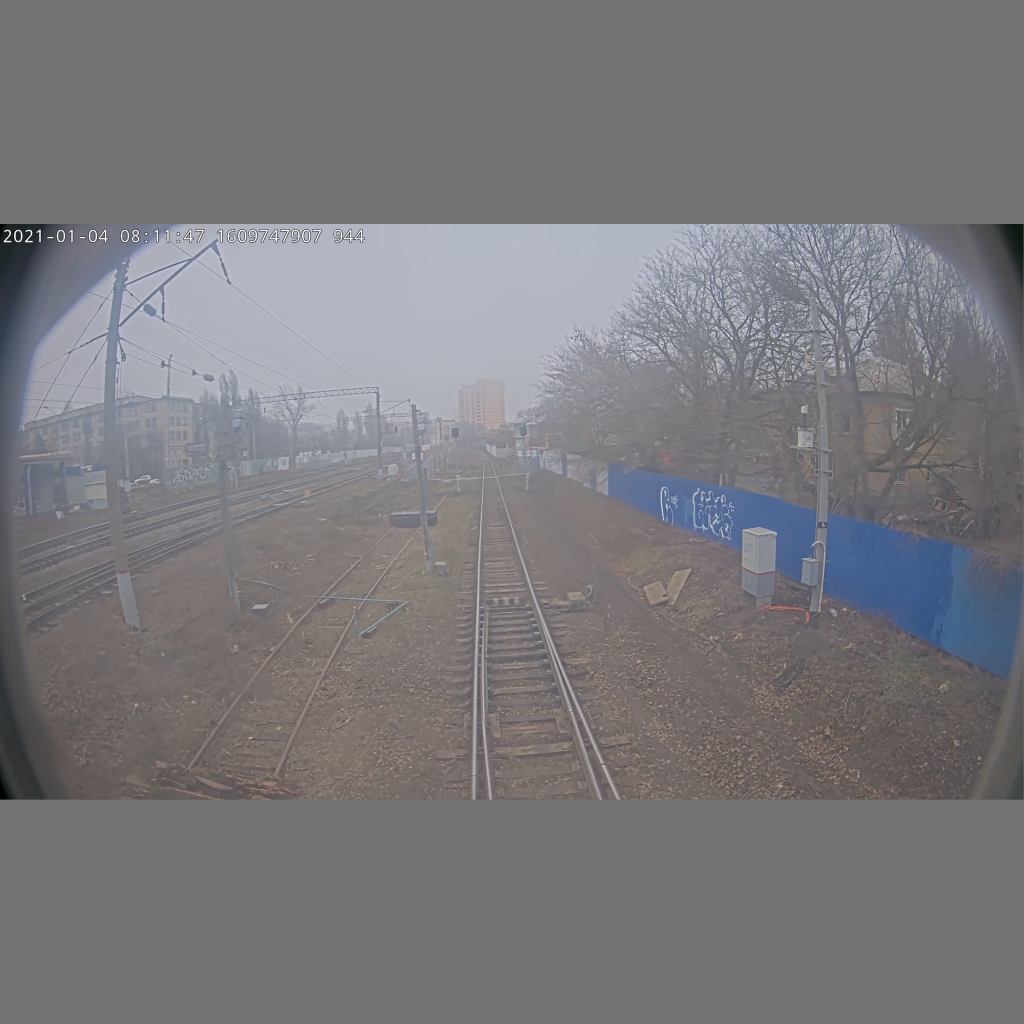

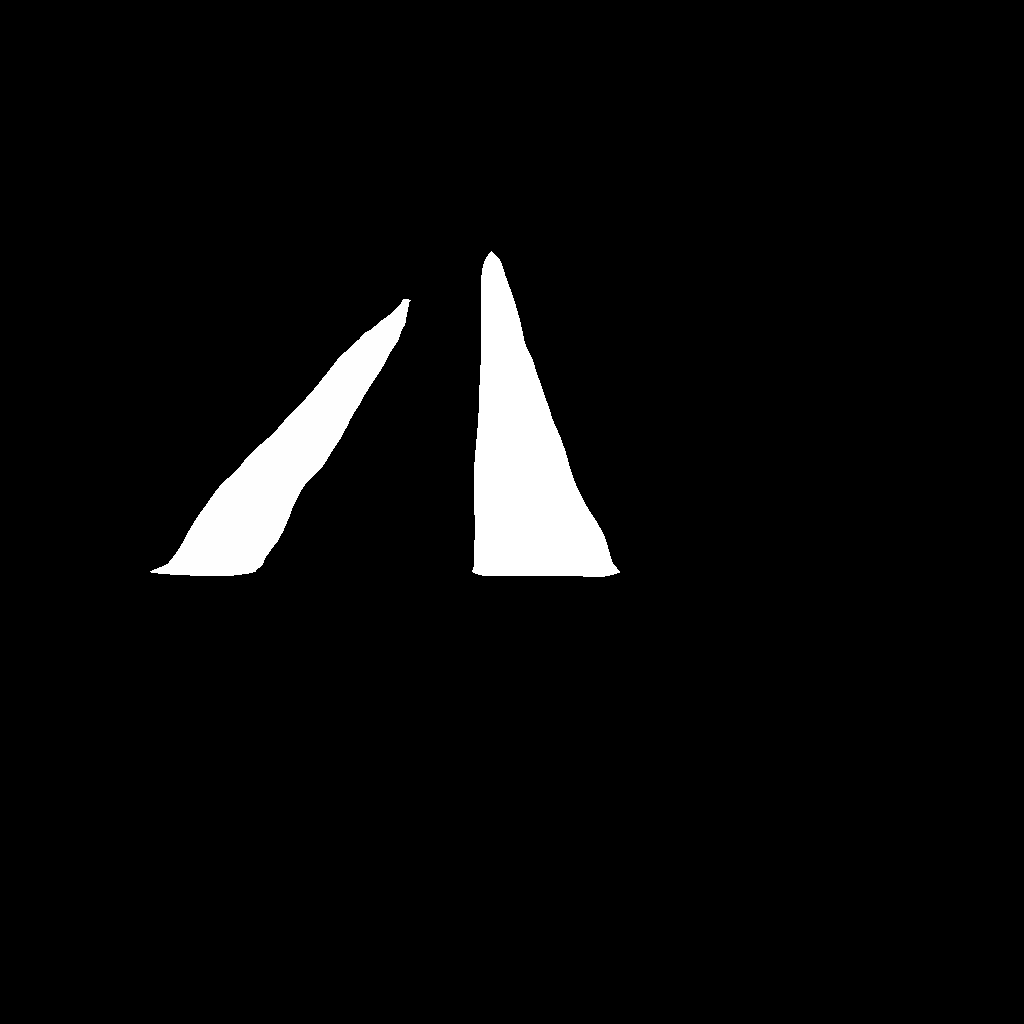

tensor(-10.2315, device='cuda:0', grad_fn=<MinBackward1>) tensor(22.4351, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([1, 4, 1024, 1024])


In [17]:
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, ToPILImage
from PIL import Image
import torch
import numpy as np
import cv2
from utils.image_utils import create_square_crop_by_detection

trainer.net.load_state_dict(
    torch.load(
        '/media/alexey/SSDData/experiments/railway_segmentation/super_gradients/DDRNET_23_SLIM/ckpt_latest.pth'
    )['net']
)

demo_img_path = '/media/alexey/HDDData/datasets/railway/RZD_Segmentation/train/images/img_0.0037125204351783347.png'

img = cv2.cvtColor(cv2.imread(demo_img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img = create_square_crop_by_detection(
    img,
    [0, 0, *img.shape[:2][::-1]],
    pad_value=114
)
img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
pil_img = Image.fromarray(img)

# Resize the image and display
display(pil_img)

# Run pre-proccess - transforms to tensor and apply normalizations.
img = torch.from_numpy(img.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).cuda()

# Run inference
model = trainer.net
model = model.eval()
mask = model(img)

print(mask.min(), mask.max(), mask.shape)

mask = mask.argmax(dim=1)

# Run post-proccess - apply sigmoid to output probabilities, then apply hard
# threshold of 0.5 for binary mask prediction. 
# mask = torch.sigmoid(mask).gt(0.5).squeeze()
mask = ToPILImage()(mask.float())
display(mask)